## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

%matplotlib inline

## Importing Dataset

In [2]:
df = pd.read_csv('breast-cancer-wisconsin.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


- dataset needs column names 
- this is obtained directly from metadata

## Metadata

   ####  Attribute                     Domain
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10  
   10. Mitoses                       1 - 10  
   11. Class:                        (2 for benign, 4 for malignant)

In [3]:
class_names = ['Sample_code_number' ,  
'Clump_Thickness',
'UniformCellSize',
'UniformCellShape',
'MarginalAdhesion',
'SingleEpithelialCellSize',
'BareNuclei',
'BlandChromatin',
'NormalNucleoli',
'Mitoses',
'Class',]

In [4]:
df.columns = class_names
df.head()

,Sample_code_number,Clump_Thickness,UniformCellSize,UniformCellShape,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
df.drop(columns='Sample_code_number',inplace = True)

## Missing Values
- metadata mentions that '?' means missing values

In [6]:
df.isna().sum(axis=0)

Clump_Thickness             0
UniformCellSize             0
UniformCellShape            0
MarginalAdhesion            0
SingleEpithelialCellSize    0
BareNuclei                  0
BlandChromatin              0
NormalNucleoli              0
Mitoses                     0
Class                       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Clump_Thickness           699 non-null    int64 
 1   UniformCellSize           699 non-null    int64 
 2   UniformCellShape          699 non-null    int64 
 3   MarginalAdhesion          699 non-null    int64 
 4   SingleEpithelialCellSize  699 non-null    int64 
 5   BareNuclei                699 non-null    object
 6   BlandChromatin            699 non-null    int64 
 7   NormalNucleoli            699 non-null    int64 
 8   Mitoses                   699 non-null    int64 
 9   Class                     699 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


In [8]:
df['BareNuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

- BareNuclei is an object because of presence of '?' representing missing values
- Will replace this with nan and later impute using KNN imputer

In [9]:
df.replace('?',np.nan,inplace=True)

In [10]:
df.isna().sum(axis=0)

Clump_Thickness              0
UniformCellSize              0
UniformCellShape             0
MarginalAdhesion             0
SingleEpithelialCellSize     0
BareNuclei                  16
BlandChromatin               0
NormalNucleoli               0
Mitoses                      0
Class                        0
dtype: int64

## Data Relationships

<AxesSubplot:>

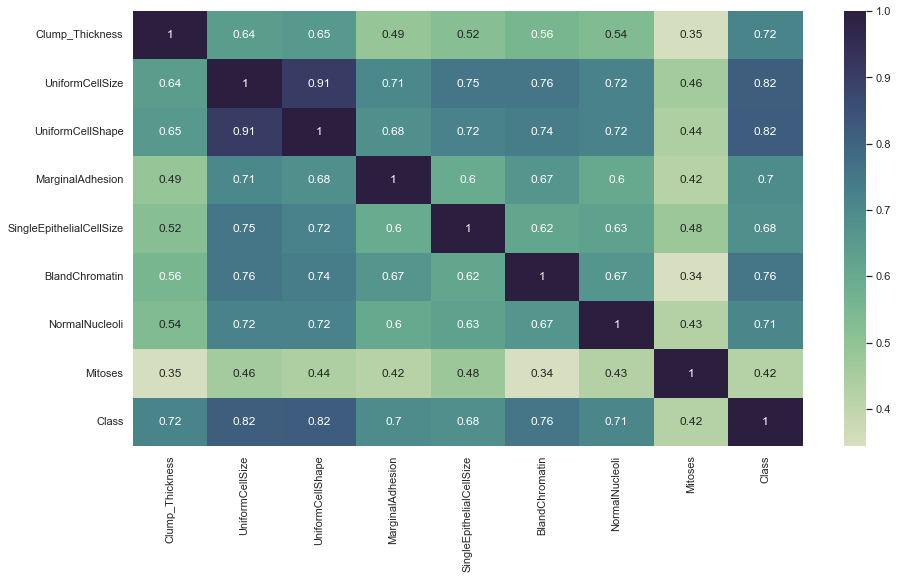

In [11]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.corr(),
            annot=True, 
            cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))

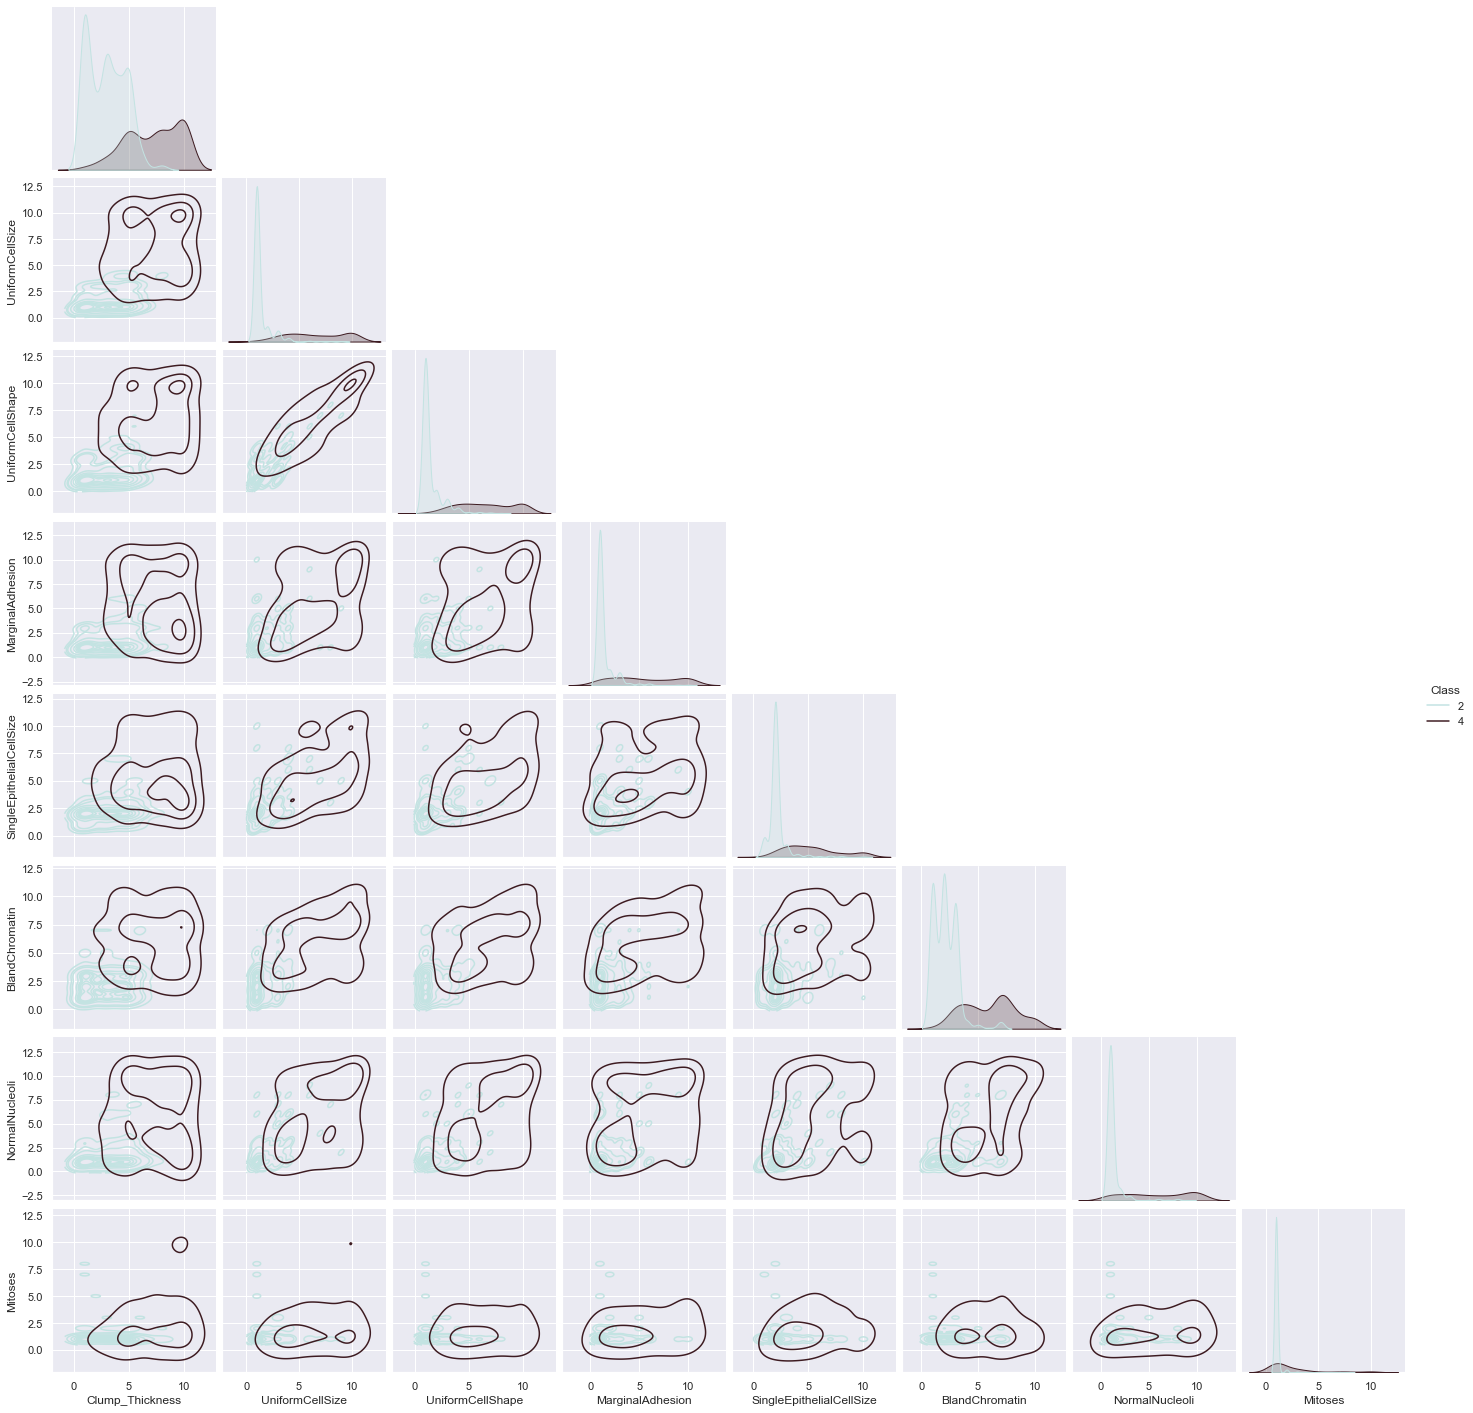

In [12]:
sns.pairplot(data=df,
             hue = 'Class',
             palette=sns.cubehelix_palette(start=0.5,rot=0.75,n_colors=2),
             corner = True,
             kind='kde')

### Conclusion
- All explanatory variables seem to have a good predicting power individually for the target variables
- Multicollinearity need not be addressed as I plan to use a SVC

## Model Selection

### Parameter Grid for GridSearch

In [13]:
para_dict = {
    'C' : list(range(1,10)),
    'kernel' : ['linear', 'poly', 'rbf'],
    'degree' : list(range(1,5)),
    'gamma' : ['scale','auto']
}

### Pipeline
- Using KNNImputer for missing values
- Scaling the data for faster performance
- Using a Support Vector Classifier for classification

In [14]:
model_para_search = Pipeline([
    ('Imputer',KNNImputer()),
    ('Scaler',StandardScaler()),
    ('GridSearchCV',GridSearchCV(
                                estimator=SVC(),
                                param_grid=para_dict,
                                refit=True,
                                cv = 10,
                                return_train_score=True))
])

### Train Test Split

In [15]:
X = df.drop(columns='Class')
y = df['Class']
X.head()

,Clump_Thickness,UniformCellSize,UniformCellShape,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


In [16]:
X_train , X_test , y_train, y_test = train_test_split(X,y,random_state=42,train_size=0.7)

### Check for Imbalanced Classes

<AxesSubplot:>

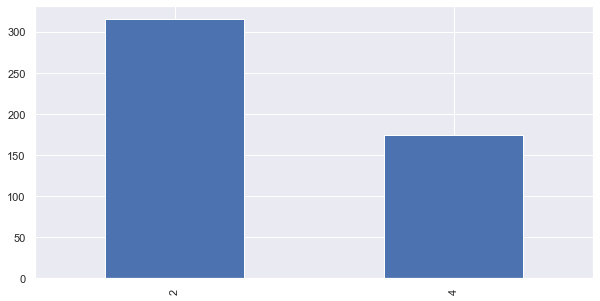

In [17]:
sns.set(rc = {'figure.figsize':(10,5)})
y_train.value_counts().plot(kind='bar')

- classes are balanced within reason

In [18]:
model_para_search.fit(X_train,y_train)

Pipeline(steps=[('Imputer', KNNImputer()), ('Scaler', StandardScaler()),
                ('GridSearchCV',
                 GridSearchCV(cv=10, estimator=SVC(),
                              param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          'degree': [1, 2, 3, 4],
                                          'gamma': ['scale', 'auto'],
                                          'kernel': ['linear', 'poly', 'rbf']},
                              return_train_score=True))])

### Obtain Best Parameters 

In [19]:
best_params = model_para_search['GridSearchCV'].best_params_

### Final Model Using Best Parameters

In [20]:
model = Pipeline([
    ('Imputer',KNNImputer()),
    ('Scaler',StandardScaler()),
    ('SVC',SVC(**best_params))
])

### Cross Validation Score

In [21]:
scores = cross_val_score(estimator=model,
                         X=X_train,y=y_train,
                         cv=10)
print("Accuracy Obtained : {0:.2f}%".format(100*scores.mean()))

Accuracy Obtained : 96.73%


In [22]:
scores

array([0.97959184, 0.97959184, 0.93877551, 0.95918367, 0.97959184,
       0.95918367, 0.97959184, 0.97959184, 0.95918367, 0.95833333])

In [23]:
model.fit(X_train,y_train)

Pipeline(steps=[('Imputer', KNNImputer()), ('Scaler', StandardScaler()),
                ('SVC', SVC(C=3, degree=1, kernel='linear'))])

### Accuracy Score

In [24]:
print("Accuracy Obtained : {0:.2f}%".format(100*model.score(X_test,y_test)))

Accuracy Obtained : 96.67%


## Performance Metrics

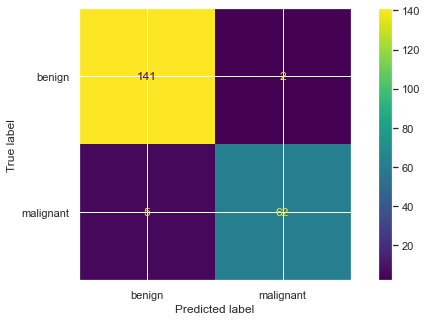

In [25]:
cm = confusion_matrix(y_true=y_test, 
                      y_pred=model.predict(X_test))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(rc = {'figure.figsize':(10,5)})win
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['benign','malignant']).plot()

In [26]:
print(classification_report(y_test, y_pred = model.predict(X_test), labels = [2,4] , target_names=['benign','malignant']))

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98       143
   malignant       0.97      0.93      0.95        67

    accuracy                           0.97       210
   macro avg       0.97      0.96      0.96       210
weighted avg       0.97      0.97      0.97       210

